# Comparison of predictions

- See preprocessing of gene expression and prediction were done in CaDRReS2/pipeline/* and 03_*
- Convert predicted delta to cv to cell death percentage

In [445]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from collections import Counter

sns.set(font_scale=1.5)
sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
from IPython.display import HTML, display

In [362]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
mpl.rc("savefig", dpi=300)

##### Compare between cell line prediction and cell type-specific prediction

In [363]:
dosage_shifted = False

for experimental validation

In [364]:
dosage_used = '3 fold' # All for HN, '9 fold' '3 fold' 'Median IC50' 

for calculating % cell death

In [365]:
# log2_median_ic50, log2_median_ic50_9f, log2_median_ic50_hn, log2_median_ic50_9f_hn, log2_median_ic50_3f_hn, log2_max_conc
dosage_ref = 'log2_median_ic50_hn' # log2_median_ic50_hn | log2_median_ic50_3f_hn
model_name = 'hn_drug_cw_dw10_100000_model'

Read predictions

In [366]:
current_dir = '../result/HN_model/TMM/'
# current_dir = '../result/HN_model/TMM_p95/'
# current_dir = '../result/HN_model/mat_norm/'
# current_dir = '../result/HN_model/mat_norm_p95/'
# current_dir = '../result/HN_model/mat_norm_log2_p95/'

In [367]:
if dosage_shifted:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
else:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}.csv'.format(dosage_ref, model_name))

Read experimental data

In [368]:
##### Combined replicate #####

validation_fname_list = ['../result/validation/validation_triplicate_2019_09_13.xlsx', '../result/validation/validation_replicates_2019_06_24.xlsx']

cv_single_df_list = []
cv_combi_df_list = []

# TO UPDATE: should we calculate average of two experiments?

for validation_fname in validation_fname_list:

    cv_single_df = pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2])
    cv_single_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_single_df = cv_single_df.reset_index().groupby(['File name', 'Dosage', 'Drug']).median().reset_index().drop(['Replicate'], axis=1)

    cv_combi_df = pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])
    cv_combi_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_combi_df = cv_combi_df.reset_index().groupby(['File name', 'Dosage', 'Drug']).median().reset_index().drop(['Replicate'], axis=1)
    
    cv_single_df_list += [cv_single_df]
    cv_combi_df_list += [cv_combi_df]

cv_df = pd.concat(cv_single_df_list + cv_combi_df_list, axis=0)
cv_df = cv_df[~cv_df['Drug'].isin(['DMSO', 'Staurosporin'])]
cv_df.head()

,File name,Dosage,Drug,HN120,HN137,HN148,HN159,HN160,HN182
0,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,56.98,64.20,38.30,25.42,96.90,67.09
2,validation_triplicate_2019_09_13.xlsx,3 fold,Docetaxel,80.69,67.84,78.09,81.28,86.22,70.59
3,validation_triplicate_2019_09_13.xlsx,3 fold,Doxorubicin,64.28,53.55,74.85,77.77,85.36,54.75
4,validation_triplicate_2019_09_13.xlsx,3 fold,Epothilone B,47.77,37.20,68.23,61.31,79.23,44.03
5,validation_triplicate_2019_09_13.xlsx,3 fold,Gefitinib,70.12,70.88,52.59,73.60,102.32,83.02


In [369]:
##### Not combined replicate #####

# validation_fname_list = ['../result/validation/validation_triplicate_2019_09_13.xlsx', '../result/validation/validation_replicates_2019_06_24.xlsx']

# cv_single_df_list = []
# cv_combi_df_list = []

# for validation_fname in validation_fname_list:

#     cv_single_df = pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2])
#     cv_single_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
#     cv_single_df = cv_single_df.reset_index()

#     cv_combi_df = pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])
#     cv_combi_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
#     cv_combi_df = cv_combi_df.reset_index()
    
#     cv_single_df_list += [cv_single_df]
#     cv_combi_df_list += [cv_combi_df]

# cv_df = pd.concat(cv_single_df_list + cv_combi_df_list, axis=0)
# cv_df = cv_df[~cv_df['Drug'].isin(['DMSO', 'Staurosporin'])]
# cv_df.head()

In [370]:
# patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160', 'HN182']
patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN160']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN159']
# patient_list = ['HN120', 'HN137', 'HN148', 'HN160']

# single_drug_id_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302] + [1012]
# single_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
# combi_drug_list = ['Docetaxel|Afatinib', 'Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Epothilone B|Afatinib', 'Gefitinib|Afatinib', 'Gefitinib|Epothilone B'] + ['Afatinib|Obatoclax Mesylate', 'Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

single_drug_id_list = [1007, 133, 201, 1010] + [182, 301, 302] + [1012]
single_drug_list = ['Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
combi_drug_list = ['Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Gefitinib|Epothilone B'] + ['Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

# single_drug_id_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302]
# single_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103']
# combi_drug_list = ['Docetaxel|Afatinib', 'Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Epothilone B|Afatinib', 'Gefitinib|Afatinib', 'Gefitinib|Epothilone B'] + ['Afatinib|Obatoclax Mesylate', 'Epothilone B|PI-103']

# single_drug_id_list = [1007, 133, 1010, 182, 301, 302]
# single_drug_list = ['Docetaxel', 'Doxorubicin', 'Gefitinib', 'Obatoclax Mesylate', 'PHA-793887', 'PI-103']
# combi_drug_list = ['Docetaxel|Gefitinib']

In [371]:
# read reference dosages file
dosage_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
dosage_df = dosage_df.loc[single_drug_id_list]

In [372]:
##### Check consistency across triplicate #####

# validation_fname = validation_fname_list[0]

# cv_new_df = pd.concat([pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2]), pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])], axis=0).reset_index()
# cv_new_df = cv_new_df[~cv_new_df['Drug'].isin(['DMSO', 'Staurosporin'])]
# cv_new_df = cv_new_df.set_index(['Drug', 'Dosage', 'Replicate']).stack().reset_index()
# cv_new_df.columns = ['Drug', 'Dosage', 'Replicate', 'Patient', 'Viability']
# cv_new_df = cv_new_df.groupby(['Dosage', 'Drug', 'Patient', 'Replicate']).sum().unstack()

# sns.pairplot(cv_new_df, plot_kws={'s':10, 'alpha':0.75, 'linewidth':0}, diag_kws={'bins':20}, aspect=1.15)

##### Preprocess predicted and observed

In [373]:
obs_kill_df = 100 - cv_df.set_index(['Dosage', 'Drug', 'File name']).astype(float)
obs_kill_df = obs_kill_df.loc[dosage_used]

In [374]:
obs_kill_df.head(10)

,,HN120,HN137,HN148,HN159,HN160,HN182
Drug,File name,,,,,,
Afatinib,validation_triplicate_2019_09_13.xlsx,43.02,35.80,61.70,74.58,3.10,32.91
Docetaxel,validation_triplicate_2019_09_13.xlsx,19.31,32.16,21.91,18.72,13.78,29.41
Doxorubicin,validation_triplicate_2019_09_13.xlsx,35.72,46.45,25.15,22.23,14.64,45.25
Epothilone B,validation_triplicate_2019_09_13.xlsx,52.23,62.80,31.77,38.69,20.77,55.97
Gefitinib,validation_triplicate_2019_09_13.xlsx,29.88,29.12,47.41,26.40,-2.32,16.98
Vorinostat,validation_triplicate_2019_09_13.xlsx,12.48,9.18,11.36,4.37,2.63,6.82
Afatinib,validation_replicates_2019_06_24.xlsx,48.29,17.19,46.80,76.23,1.02,33.43
Docetaxel,validation_replicates_2019_06_24.xlsx,23.50,22.50,27.10,20.15,1.96,17.50
Epothilone B,validation_replicates_2019_06_24.xlsx,57.95,62.88,51.80,45.79,17.06,54.70


In [375]:
pred_single_df = pred_single_df[pred_single_df['drug_id'].isin(single_drug_id_list)]

pred_combi_df = pred_combi_df[pred_combi_df['drug_id_A'].isin(single_drug_id_list) & pred_combi_df['drug_id_B'].isin(single_drug_id_list)]

pred_combi_df.loc[:, 'Combi Name 1'] = pred_combi_df['drug_name_A'].values + '|' + pred_combi_df['drug_name_B'].values
pred_combi_df.loc[:, 'Combi Name 2'] = pred_combi_df['drug_name_B'].values + '|' + pred_combi_df['drug_name_A'].values

temp1 = pred_combi_df['Combi Name 1'][pred_combi_df['Combi Name 1'].isin(combi_drug_list)]
temp2 = pred_combi_df['Combi Name 2'][pred_combi_df['Combi Name 2'].isin(combi_drug_list)]
combi_name = pd.concat([temp1, temp2]).values

pred_combi_df = pd.concat([pred_combi_df[pred_combi_df['Combi Name 1'].isin(combi_drug_list)], pred_combi_df[pred_combi_df['Combi Name 2'].isin(combi_drug_list)]])
pred_combi_df.loc[:, 'Combi Name'] = combi_name
pred_combi_df = pred_combi_df[pred_combi_df['Combi Name'].isin(combi_drug_list)]

In [376]:
pred_single_df.head()

,patient,drug_id,cluster,cluster_p,cluster_delta,delta,cluster_kill,kill,drug_name
4,HN120,1007,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,3.0211910963965|2.6922616957096|4.045923540528...,3.25,10.966865579688|13.398973100733|5.708576760594...,8.56,Docetaxel
5,HN120,1010,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,2.2120065715556|2.054458223014|2.7066706527924...,2.28,17.751923626333|19.402871920459|13.28350439875...,15.29,Gefitinib
6,HN120,1012,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-0.13997109033663|-0.10307829102396|-0.2419478...,-0.19,52.423613343105|51.785451192123|54.18283850189...,50.76,Vorinostat
24,HN120,133,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-2.7687641637171|-2.4038647234774|-1.348018671...,-1.97,87.20448532958|84.107280954653|71.796210371006...,76.01,Doxorubicin
44,HN120,182,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-1.8073124903169|-1.1619505525366|-0.640736270...,-1.10,77.777269427724|69.112899383857|60.92413858820...,65.18,Obatoclax Mesylate


In [377]:
pred_combi_df.head()

,patient,drug_id_A,drug_name_A,drug_id_B,drug_name_B,cluster,cluster_p,cluster_kill_A,cluster_kill_B,cluster_kill_C,kill_A,kill_B,kill_C,improve,improve_p,kill_entropy,sum_kill_dif,Combi Name 1,Combi Name 2,Combi Name
9,HN120,1007,Docetaxel,201,Epothilone B,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,10.966865579688|13.398973100733|5.708576760594...,82.789348726345|76.411112770076|44.33477944134...,84.676817716916|79.571781424776|47.51247128588...,8.56,61.32,63.91,2.59,0.04,0.00,223.31,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B
10,HN120,1007,Docetaxel,1010,Gefitinib,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,10.966865579688|13.398973100733|5.708576760594...,17.751923626333|19.402871920459|13.28350439875...,26.771959604112|30.2020594318|18.23378211425|2...,8.56,15.29,22.41,7.12,0.47,0.00,28.34,Docetaxel|Gefitinib,Gefitinib|Docetaxel,Docetaxel|Gefitinib
20,HN120,133,Doxorubicin,1012,Vorinostat,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,87.20448532958|84.107280954653|71.796210371006...,52.423613343105|51.785451192123|54.18283850189...,93.912356465661|92.337397218982|87.07782415709...,76.01,50.76,86.24,10.23,0.13,0.00,106.86,Doxorubicin|Vorinostat,Vorinostat|Doxorubicin,Doxorubicin|Vorinostat
24,HN120,201,Epothilone B,302,PI-103,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,82.789348726345|76.411112770076|44.33477944134...,72.626289048567|81.138141816387|93.96676124936...,95.288806067491|95.550697543599|96.64158434263...,61.32,79.72,91.05,11.33,0.14,0.94,96.34,Epothilone B|PI-103,PI-103|Epothilone B,Epothilone B|PI-103
45,HN137,1007,Docetaxel,201,Epothilone B,E1|E2|E3|F1|F2|F3,0.34090909090909|0.085227272727273|0.073863636...,19.471163888112|15.55323143769|12.668331585559...,58.834636851903|13.812038079204|33.49990323163...,66.850012175605|27.217051268174|41.92435599496...,14.64,44.27,51.72,7.46,0.17,0.44,134.21,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B


### Compare for all lines and drugs

In [378]:
pred_single_kill_df = pred_single_df[['patient', 'drug_name', 'kill']].pivot(index='drug_name', columns='patient', values='kill')
pred_single_delta_df = pred_single_df[['patient', 'drug_name', 'delta']].pivot(index='drug_name', columns='patient', values='delta')
pred_combi_kill_df = pred_combi_df[['patient', 'Combi Name', 'kill_C']].pivot(index='Combi Name', columns='patient', values='kill_C')

obs_single_kill_df = obs_kill_df.loc[single_drug_list, patient_list]
obs_combi_kill_df = obs_kill_df.loc[combi_drug_list, patient_list]

In [379]:
sns.set(font_scale=1.25)
sns.set_style('ticks')

cmap = plt.cm.get_cmap('tab10', 10)
colors = cmap(np.linspace(0, 1, 10))
patient_color_dict = dict(zip(patient_list, colors[0:len(patient_list)]))
drug_color_dict = dict(zip(single_drug_list, colors[0:len(single_drug_list)]))
combi_color_dict = dict(zip(combi_drug_list, colors[0:len(combi_drug_list)]))

drug_marker_dict = dict(zip(single_drug_list, ['o', 'v', '^', '<', '>', 'd', 's']))
combi_marker_dict = dict(zip(combi_drug_list, ['p', '*', 'P', 'X', 'h']))

##### For single drug

Text(0.5, 0, 'Observed % cell death\n(3 fold)')

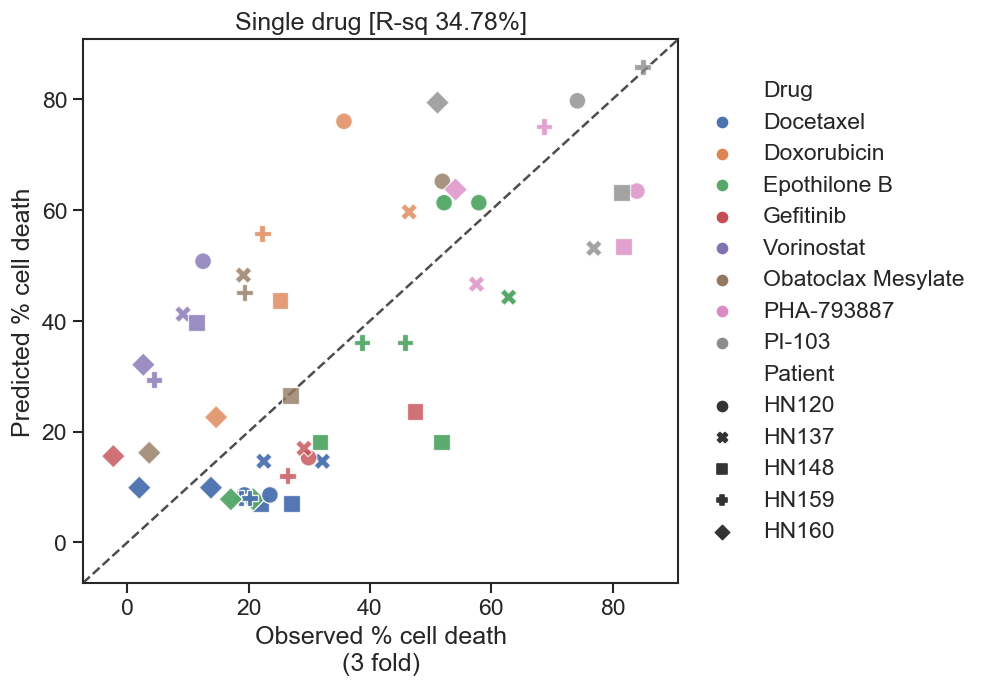

In [380]:
obs_df = obs_single_kill_df.loc[single_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug', 'File name', 'Patient', 'Observed % cell death']

# pred_df = pred_single_kill_df.loc[single_drug_list, patient_list].stack().reset_index()
pred_df = pred_single_kill_df.loc[[d[0] for d in obs_single_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug', 'Patient', 'Predicted % cell death']

sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

scatter_df = pd.merge(obs_df, pred_df, how='left',left_on=['Drug', 'Patient'], right_on=['Drug', 'Patient'])
sns.scatterplot(data=scatter_df, x='Observed % cell death', y='Predicted % cell death', hue='Drug', style='Patient', s=100, alpha=0.8, ax=ax)
# sns.regplot(data=scatter_df, x='Observed % cell death', y='Predicted % cell death', x_ci='ci', ci=99, scatter=False, color='grey', ax=ax)

vmin = scatter_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, vmax+5))
ax.set_ylim((vmin-5, vmax+5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

# scor, pval = stats.pearsonr(scatter_df['Observed % cell death'].values, scatter_df['Predicted % cell death'].values)
# ax.set_title('Single drug | Pearson r = {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(scatter_df['Observed % cell death'].values, scatter_df['Predicted % cell death'].values)
ax.set_title('Single drug [R-sq {:.2f}%]'.format(r2*100))

ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

In [381]:
obs = scatter_df['Observed % cell death'].values
pred = scatter_df['Predicted % cell death'].values

In [382]:
ss_reg = np.sum(np.square(pred - np.mean(obs)))
ss_tot = np.sum(np.square(obs - np.mean(obs)))
ss_res = np.sum(np.square(obs - pred))

ss_tot, ss_reg, ss_res

(35106.20424640014, 38237.74277337051, 22897.576097250887)

In [383]:
r, pval = stats.pearsonr(obs, pred)
r, r**2, metrics.r2_score(obs, pred)

(0.6923809688004825, 0.47939140595709473, 0.34776269355298217)

In [384]:
# drug_list = sorted(list(set(scatter_df['Drug'])))
# for drug in drug_list:
#     d_y = scatter_df[scatter_df['Drug']==drug]['Observed % cell death'].values
#     d_y_hat = scatter_df[scatter_df['Drug']==drug]['Predicted % cell death'].values
#     print ("{} [R-sq = {:.2f}%]".format(drug, metrics.r2_score(d_y, d_y_hat)*100))

In [385]:
# patient_list = sorted(list(set(scatter_df['Patient'])))
# for patient in patient_list:
#     d_y = scatter_df[scatter_df['Patient']==patient]['Observed % cell death'].values
#     d_y_hat = scatter_df[scatter_df['Patient']==patient]['Predicted % cell death'].values
#     print ("{} [R-sq = {:.2f}%]".format(patient, metrics.r2_score(d_y, d_y_hat)*100))

##### For combi drug

Text(0.5, 0, 'Observed % cell death\n(3 fold)')

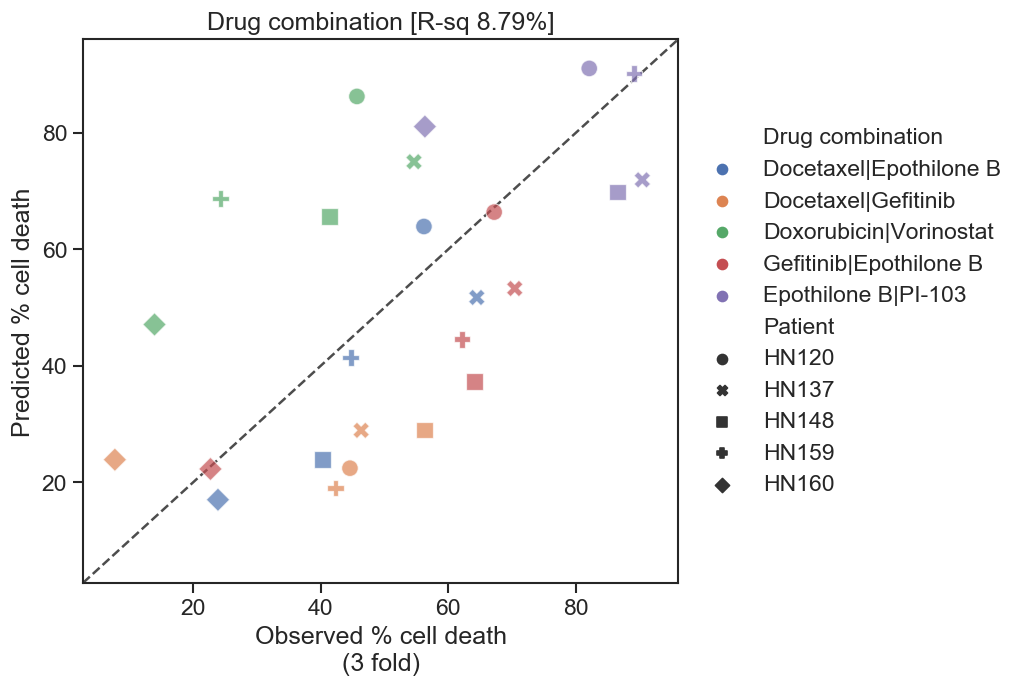

In [386]:
obs_df = obs_combi_kill_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'File name', 'Patient', 'Observed % cell death']

pred_df = pred_combi_kill_df.loc[[d[0] for d in obs_combi_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % cell death']

sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

scatter_df = pd.merge(obs_df, pred_df, how='left', left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])

sns.scatterplot(data=scatter_df, x='Observed % cell death', y='Predicted % cell death', hue='Drug combination', style='Patient', s=100, alpha=0.7)
# sns.regplot(data=scatter_df, x='Observed % cell death', y='Predicted % cell death', x_ci='ci', ci=99, scatter=False, color='grey')
# plt.plot([0, 100], [0, 100], ls="--", c=".3")

vmin = scatter_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, vmax+5))
ax.set_ylim((vmin-5, vmax+5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

# scor, pval = stats.pearsonr(scatter_df['Observed % cell death'].values, scatter_df['Predicted % cell death'].values)
# ax.set_title('Drug combination | {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(scatter_df['Observed % cell death'].values, scatter_df['Predicted % cell death'].values)
ax.set_title('Drug combination [R-sq {:.2f}%]'.format(r2*100))

ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

##### Compare improvement of drug combi over single drugs

In [387]:
pred_combi_imp_df = pred_combi_df[['patient', 'Combi Name', 'improve']].pivot(index='Combi Name', columns='patient', values='improve')
pred_combi_pimp_df = pred_combi_df[['patient', 'Combi Name', 'improve_p']].pivot(index='Combi Name', columns='patient', values='improve_p')

pred_combi_imp_df = pred_combi_imp_df.loc[combi_drug_list, patient_list]
pred_combi_pimp_df = pred_combi_pimp_df.loc[combi_drug_list, patient_list]

In [388]:
pred_combi_imp_df

patient,HN120,HN137,HN148,HN159,HN160
Combi Name,,,,,
Docetaxel|Epothilone B,2.59,7.46,5.74,5.30,7.12
Docetaxel|Gefitinib,7.12,11.93,5.31,6.97,8.30
Gefitinib|Epothilone B,5.06,8.99,13.67,8.45,6.70
Epothilone B|PI-103,11.33,18.84,6.63,4.37,1.68
Doxorubicin|Vorinostat,10.23,15.36,21.91,12.92,15.01


In [389]:
# TEMPORARY: using averge response

temp_df = obs_kill_df.loc[combi_drug_list].reset_index().drop('File name', axis=1)
temp_df = temp_df.groupby('Drug').mean()
# temp_df = temp_df.loc[~temp_df.index.duplicated(keep='first')]
temp_df

,HN120,HN137,HN148,HN159,HN160,HN182
Drug,,,,,,
Docetaxel|Epothilone B,56.18,64.47,40.28,44.71,23.88,60.23
Docetaxel|Gefitinib,44.57,46.33,56.31,42.29,7.71,38.34
Doxorubicin|Vorinostat,45.67,54.62,41.34,24.28,13.93,56.48
Epothilone B|PI-103,82.10,90.42,86.49,89.11,56.33,40.31
Gefitinib|Epothilone B,67.19,70.42,64.15,62.17,22.70,65.37


In [390]:
imp_results = []
pimp_results = []
for c, data in temp_df.loc[combi_drug_list, patient_list].iterrows():
    a, b = c.split('|')
    
    c_kill = data.values
    best_kill = obs_kill_df.loc[[a, b]].max()[patient_list]
#     best_kill = obs_kill_df.loc[[a, b]].reset_index().groupby('Drug').mean()[patient_list].max()
    
#     print (c, c_kill, best_kill)
    
    imp = list((c_kill - best_kill).values)
    pimp = list(((c_kill - best_kill)/best_kill).values)
    
    imp_results += [[c] + imp]
    pimp_results += [[c] + pimp]
        
obs_combi_imp_df = pd.DataFrame(imp_results)
obs_combi_imp_df.columns = ['Drug combination'] + patient_list
obs_combi_imp_df = obs_combi_imp_df.set_index('Drug combination')

obs_combi_pimp_df = pd.DataFrame(pimp_results)
obs_combi_pimp_df.columns = ['Drug combination'] + patient_list
obs_combi_pimp_df = obs_combi_pimp_df.set_index('Drug combination')

obs_combi_imp_df = obs_combi_imp_df.loc[combi_drug_list, patient_list]
obs_combi_pimp_df = obs_combi_pimp_df.loc[combi_drug_list, patient_list]

Text(0.5, 1.0, 'Single VS Combi [R-sq -9.17%]')

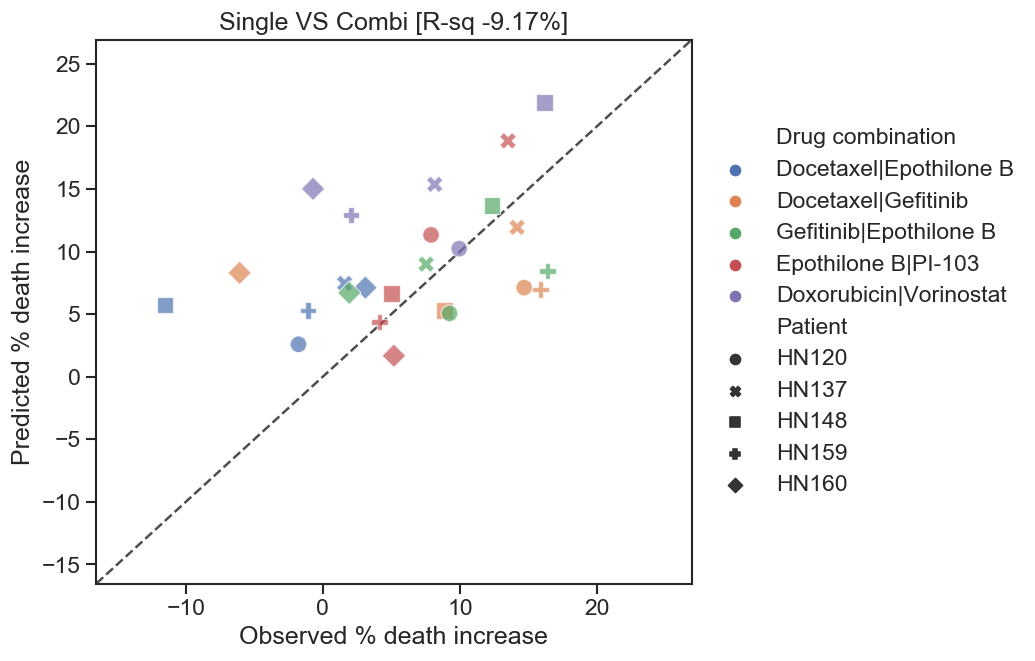

In [391]:
obs_df = obs_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'Patient', 'Observed % death increase']

pred_df = pred_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % death increase']

fig, ax = plt.subplots(figsize=(8,6))
scatter_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])

sns.scatterplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', hue='Drug combination', style='Patient', s=100, alpha=0.7)
# sns.regplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', x_ci='ci', ci=99, scatter=False, color='grey')
# plt.plot([0, 25], [0, 25], ls="--", c=".3")

vmin = scatter_df[['Observed % death increase', 'Predicted % death increase']].min().min()
vmax = scatter_df[['Observed % death increase', 'Predicted % death increase']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, vmax+5))
ax.set_ylim((vmin-5, vmax+5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

# scor, pval = stats.pearsonr(obs_df['Observed % death increase'].values, pred_df['Predicted % death increase'].values)
# ax.set_title('Single VS Combi | {:.2f} p-val < {:.2e})'.format(scor, pval))

r2 = metrics.r2_score(scatter_df['Observed % death increase'].values, scatter_df['Predicted % death increase'].values)
ax.set_title('Single VS Combi [R-sq {:.2f}%]'.format(r2*100))


(RanksumsResult(statistic=1.5229992210171794, pvalue=0.12775890031613887),
 Ttest_indResult(statistic=1.4788043284303884, pvalue=0.15275875196233452))

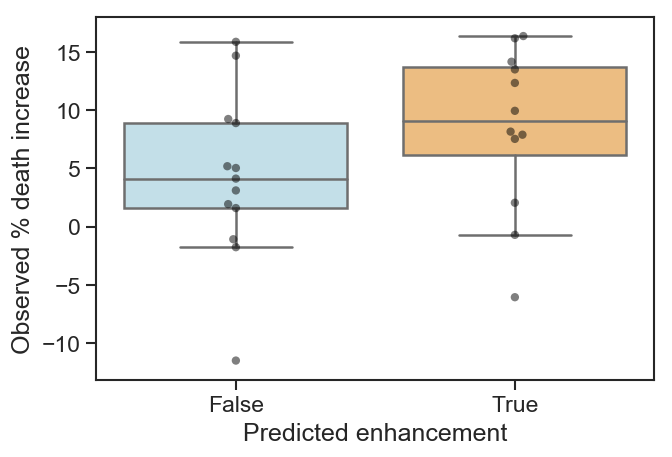

In [398]:
merge_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])
merge_df.loc[:, 'Predicted enhancement'] = merge_df['Predicted % death increase'] >= 7.5

sns.boxplot(data=merge_df, x='Predicted enhancement', y='Observed % death increase', fliersize=0, palette='RdYlBu_r')
sns.swarmplot(data=merge_df, x='Predicted enhancement', y='Observed % death increase', color='black', alpha=0.5)

x = merge_df.loc[merge_df['Predicted enhancement'], 'Observed % death increase'].values
y = merge_df.loc[~merge_df['Predicted enhancement'], 'Observed % death increase'].values
stats.ranksums(x, y), stats.ttest_ind(x, y)

In [476]:
obs = (merge_df['Observed % death increase'].values >= 10).astype(int)
pred = (merge_df['Predicted % death increase'].values >= 10).astype(int)
pred_val = merge_df['Predicted % death increase'].values

In [477]:
metrics.accuracy_score(obs, pred)

0.68

In [478]:
metrics.f1_score(obs, pred, pos_label=1)

0.5

In [479]:
metrics.f1_score(obs, pred, pos_label=0)

0.7647058823529411

In [480]:
Counter(obs)

Counter({0: 18, 1: 7})

0.615758348794063


(0, 1.1)

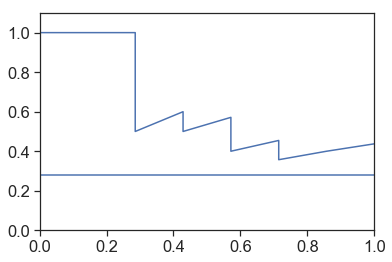

In [481]:
precision, recall, thresholds = metrics.precision_recall_curve(obs, pred_val)
plt.plot(recall, precision)

print (metrics.auc(recall, precision))

no_skill = len(obs[obs==1]) / len(obs)
plt.axhline(y=no_skill)

plt.xlim((0,1))
plt.ylim((0,1.1))